In [42]:
import os
import uuid
import warnings
from typing import List, TypedDict, Annotated

warnings.filterwarnings("ignore")

from IPython.display import Markdown


from pydantic import BaseModel, Field


from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    AIMessage,
    SystemMessage
)
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableConfig

from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter


from langchain_community.vectorstores.pgvector import PGVector

from tqdm import tqdm
from langgraph.graph import (
    StateGraph,
    START,
    END,
    MessagesState
)
from langgraph.graph.message import add_messages
from langgraph.store.base import BaseStore

from supabase import create_client

from supabase import create_client
from typing import List
import numpy as np


from dotenv import load_dotenv
load_dotenv(dotenv_path=r"C:\Users\hasee\Desktop\Legal Chatbot\.env")

True

# RAG Tool 

In [ ]:
CONNECTION_STRING = os.environ.get("CONNECTION_STRING","")
SUPERBASE_SERVICE_ROLE_KEY = os.environ.get("SUPERBASE_SERVICE_ROLE_KEY","")
SUPABASE_URL = os.environ.get("SUPABASE_URL","")
COLLECTION_NAME = "qanoon" # table in superbase




from sqlalchemy import create_engine
engine = create_engine(CONNECTION_STRING)
with engine.connect() as conn:
    print("Connected to Supabase Postgres")





# chatting llm
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
EMBEDDING = OpenAIEmbeddings(model="text-embedding-3-small")




Connected to Supabase Postgres


# Production Grade RAG

In [73]:
from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader

class LegalRAG(TypedDict):
    documents_path:str
    document:list[Document]
    chunks:list[Document] 
    vectorstore:PGVector | None
    collection_name:str
    retrieved_docs:list[Document]
    context: str 
    answer:str
    vectorstore_path:str
    messages: Annotated[list[BaseMessage], add_messages]
    doc_id: str
    sources: list[dict]

In [ ]:
class ProductionRAG:
    def __init__(self):
        self.supabase = create_client(SUPABASE_URL, SUPERBASE_SERVICE_ROLE_KEY)
        self.embedder = EMBEDDING
        self.llm = llm
    
    def ingest_document(self, file_path: str, doc_id: str):
        """Complete ingestion pipeline"""
        # Document Loader
        loader = PyPDFLoader(file_path)
        docs = loader.load()
        
        # Text Splitter
        splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200
        )
        chunks = splitter.split_documents(docs)
        print(f"Len of total chunks: {len(chunks)}")
        
        # Add metadata
        for i, chunk in enumerate(chunks):
            chunk.metadata.update({
                "doc_id": doc_id,
                "chunk_index": i,
                "file_name": os.path.basename(file_path)
            })
        
        # Store in Supabase
        self.supabase.table("documents").insert({
            "doc_id": doc_id,
            "file_name": os.path.basename(file_path),
            "metadata": {"total_chunks": len(chunks)}
        }).execute()
        
        # Batch insert chunks
        batch_size = 100
        for i in range(0, len(chunks), batch_size):
            batch = chunks[i:i + batch_size]
            texts = [c.page_content for c in batch]
            embeddings = self.embedder.embed_documents(texts)
            
            rows = [
                {
                    "doc_id": c.metadata["doc_id"],
                    "chunk_index": c.metadata["chunk_index"],
                    "content": c.page_content,
                    "embedding": emb,
                    "metadata": c.metadata
                }
                for c, emb in zip(batch, embeddings)
            ]
            
            self.supabase.table("qanoon").insert(rows).execute()
            print(f"Inserted {len(rows)} chunks")
        return len(chunks)
    

    def search_chunks(self, query: str, top_k: int = 5):
        """Search for relevant chunks"""
        query_emb = self.embedder.embed_query(query)
        
        results = self.supabase.rpc('match_chunks', {
            'query_embedding': query_emb,
            'match_count': top_k
        }).execute()
        
        return results.data
    
    
    def generate_answer(self, context: str, question: str):
        """Generate answer from context"""
        prompt = f"""
        You are an expert Legal AI Assistant for Pakistan. Your task is to answer legal questions based strictly on the provided context.

        Instructions:
        1. Source-Based Answering: Answer the question using ONLY the information provided in the Context below. Do not use outside knowledge.
        2. Specific Legal Citations: When making a statement, you must cite the specific legal authority found in the text (e.g., "Article 6 of the Constitution", "Section 302 of PPC", "Clause 3"). 
        3. Citation Format: Format citations as: [Legal Reference]** (Found in: Chunk ID/Source).
            Example: "Every citizen has the right to a fair trial as per Article 10-A (Source: Chunk 2, constitution.pdf).."
        4. No Hallucinations:** If the provided context does not contain the answer, state: "The provided context does not contain sufficient information to answer this question."

        Context:
        {context}

        Question:
        {question}

        Answer:
        """

        
        response = self.llm.invoke(prompt)
        return response.content


# initilize the class
# rag_system = ProductionRAG()

```bash
You can instantiate it once and use its .run(state) method as a single node in a larger workflow:
class LegalAssistantGraph:
    def __init__(self):
        self.rag_subgraph = LegalRAGGraph()
        self.workflow = self._build_main_graph()

    def _rag_node(self, state):
        # RAG subgraph is a single node here
        return self.rag_subgraph.run(state)

    def _main_workflow(self, state):
        state = self._rag_node(state)
        # Add memory/tool nodes here
        return state
```

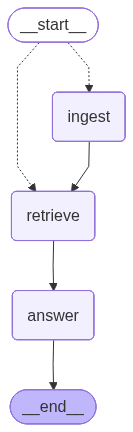

In [93]:
from supabase import create_client

class LegalRAGGraph:
    def __init__(self):
        self.rag = ProductionRAG()
        self.workflow = self._build_graph()
    
    def _ingest_node(self, state: LegalRAG):
        chunks = self.rag.ingest_document(state["documents_path"], state["doc_id"])
        state["chunks_count"] = chunks
        return state
    
    def _retrieve_node(self, state: LegalRAG):
        question = state["messages"][-1].content # get last message
        docs = self.rag.search_chunks(question)    # search for chunks similar to query using RPC(superbase)
        state["retrieved_docs"] = docs
        return state
    
    def _answer_node(self, state: LegalRAG):
        # context = "\n\n".join([d["content"] for d in state["retrieved_docs"]])
        context = "\n\n".join(
            [f"Chunk ID: {d['chunk_index']}, File: {d['metadata']['file_name']}\nContent: {d['content']}"
            for d in state["retrieved_docs"]]
        )

        answer = self.rag.generate_answer(context, state["messages"][-1].content)
        state["answer"] = answer
        state["sources"] = [
            {"doc_id": d["doc_id"], "chunk_index": d["chunk_index"], "file_name": d["metadata"]["file_name"]}
            for d in state["retrieved_docs"]
        ]
        state["messages"].append(AIMessage(content=answer))
        return state

    
    def _build_graph(self):
        workflow = StateGraph(LegalRAG)
    
        workflow.add_node("ingest", self._ingest_node)
        workflow.add_node("retrieve", self._retrieve_node)
        workflow.add_node("answer", self._answer_node)
        
        workflow.add_conditional_edges(
            START,
            lambda s: "ingest" if s.get("documents_path") else "retrieve",
            {"ingest": "ingest", "retrieve": "retrieve"}
        )
        
        workflow.add_edge("ingest", "retrieve")
        workflow.add_edge("retrieve", "answer")
        workflow.add_edge("answer", END)
        app = workflow.compile()
        return app
    
    def getter(self):
        return self.workflow 

    def run(self, state: dict):
        return self.workflow.invoke(state)

# Usage
graph = LegalRAGGraph()

graph.getter()  # to visuzlize graph


In [94]:
# Ingest and query
import uuid
result = graph.run({
    "documents_path": "../data/Constitution and law/constitution.pdf",
    "doc_id": str(uuid.uuid4()),
    "messages": [HumanMessage(content="Summary of the document?")]
})

result = result["answer"]

Len of total chunks: 638
Inserted 100 chunks
Inserted 100 chunks
Inserted 100 chunks
Inserted 100 chunks
Inserted 100 chunks
Inserted 100 chunks
Inserted 38 chunks


In [95]:
Markdown(result)

The provided context does not contain sufficient information to answer this question.

# Using Load Vector store

In [104]:
initial_state = {
    "messages": [HumanMessage(content="what are Basic humman rights in pakistan constituion.")]
}

result2 = graph.run(initial_state)

In [105]:
Markdown(result2["answer"])

The provided context does not contain sufficient information to answer this question.

In [106]:
result2["sources"]

[{'doc_id': 'e2386159-e022-40ff-925c-1b804eb57956',
  'chunk_index': 343,
  'file_name': 'constitution.pdf'}]

In [98]:
initial_state = {
    "messages": [HumanMessage(content="Supreme court autority accroding to pakistan constitution")]
}

result2 = graph.run(initial_state)

In [99]:
Markdown(result2["answer"])

The Supreme Court of Pakistan has several authorities as outlined in the Constitution:

1. **Binding Decisions**: Any decision of the Supreme Court shall be binding on all other courts in Pakistan to the extent that it decides a question of law or enunciates a principle of law [Article 189]** (Found in: Chunk ID 334, constitution.pdf).

2. **Action in Aid**: All executive and judicial authorities throughout Pakistan are required to act in aid of the Supreme Court [Article 190]** (Found in: Chunk ID 334, constitution.pdf).

3. **Rules of Procedure**: The Supreme Court has the authority to make rules regulating its practice and procedure, subject to the Constitution and law [Article 191]** (Found in: Chunk ID 334, constitution.pdf).

4. **Original Jurisdiction**: The Supreme Court has original jurisdiction in disputes between any two or more Governments, meaning it can hear such cases to the exclusion of every other court [Article 184(1)]** (Found in: Chunk ID 327, constitution.pdf).

5. **Appellate Jurisdiction**: The Supreme Court also has appellate jurisdiction, allowing it to hear appeals from lower courts, subject to certain conditions [Article 185]** (Found in: Chunk ID 327, constitution.pdf).

6. **Appointment of Judges**: The Chief Justice and other Judges of the Supreme Court are appointed by the President in accordance with Article 175A [Article 177(1)]** (Found in: Chunk ID 320, constitution.pdf). 

These provisions collectively establish the authority and functions of the Supreme Court within the legal framework of Pakistan.